# CLEAN DATA

Remove the galactic dust, the point sources and the galactic dipole from RAW data; this is necessary to make a correct classification of the glitches.

In [1]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import statistics as sts
from scipy.linalg import lstsq

## Model constants and parameters

In [2]:
OPERATING_DAY = "095"
FILENAME_PTG = "/mnt/d/Tesi/data/HFI-143/HFI_TOI_143-PTG_R2.01_OD0" + OPERATING_DAY + ".fits"
FILENAME_RAW = "/mnt/d/Tesi/data/HFI-143/HFI_TOI_143-RAW_R2.00_OD0" + OPERATING_DAY + ".fits"
FILENAME_SCI = "/mnt/d/Tesi/data/HFI-143/HFI_TOI_143-SCI_R2.00_OD0" + OPERATING_DAY + ".fits"

DETECTOR = "143-5"

DIR = "ris/ipynb_test-clean_data-moving_average/OD" + OPERATING_DAY + "_" + DETECTOR

In [3]:
with fits.open(FILENAME_SCI) as f:
    T_CMB = f[DETECTOR].header["T_CMB"]
    SOLSYSDIR_ECL_COLAT_RAD = f[DETECTOR].header["ECL_THE"]
    SOLSYSDIR_ECL_LONG_RAD = f[DETECTOR].header["ECL_PHI"]
    SOLSYSSPEED_M_S = f[DETECTOR].header["SOLSPEED"]
    MAIN_LENGTH = len(f[DETECTOR].data.field("SIGNAL"))
    CALIBRATION_CONSTANT = f[DETECTOR].header["CALIB"]
    ZERO_POINT = f[DETECTOR].header["ZERO-PT"]

# Number of elements of the average
MA_LENGTH = 649346
# New length
NEW_LENGTH = MAIN_LENGTH - MA_LENGTH + 1

SPEED_OF_LIGHT_M_S = 2.99792458e8
PLANCK_H_MKS = 6.62606896e-34
BOLTZMANN_K_MKS = 1.3806504e-23

SOLSYS_SPEED_VEC_M_S = SOLSYSSPEED_M_S * np.array(
                                                  [
                                                   np.sin(SOLSYSDIR_ECL_COLAT_RAD) * np.cos(SOLSYSDIR_ECL_LONG_RAD),
                                                   np.sin(SOLSYSDIR_ECL_COLAT_RAD) * np.sin(SOLSYSDIR_ECL_LONG_RAD),
                                                   np.cos(SOLSYSDIR_ECL_COLAT_RAD),
                                                   ]
                                                  )

## Cleaning model

Since the purpose of this thesis is to detect glitches and not to clean up the RAW signal from the galactic signal and other signals, all points that are on the galactic plane or coincide with a point source can be ignored without any consequences.

### Mask

Load galaxy flag from the SCI data. The SCI data, taken as PTG and RAW data from the Planck Legacy Archive (PLA), are the so-called scientific data (already cleaned of various effects and glitches) and each data has a flag that indicates a peculiarity, i.e. point object, planet, galaxy plane and others. In particular, the flags of interest are those concerning the _galactic plane_ and the _point source_:
```
bit 4: StrongSignal; 1 = In Galactic plane
bit 5: StrongSource; 1 = On point source
```
Data with those flags must be discarded.

In [4]:
# Open SCI data and load the "FLAG" field
with fits.open(FILENAME_SCI) as f:
    SCI_FLAG_bits = f[DETECTOR].data.field("FLAG")
    
# Unpacks bits
SCI_FLAG_bits = np.unpackbits(SCI_FLAG_bits[:, np.newaxis], axis=1)

# Read the 4th and 5th bits
SCI_FLAG_GD = SCI_FLAG_bits[:,3]
SCI_FLAG_PS = SCI_FLAG_bits[:,4]

In [5]:
# Sum the two masks
MASK = SCI_FLAG_GD + SCI_FLAG_PS
# Make "average"
MASK = MASK[:NEW_LENGTH]

# Every value above 0 means an unacceptable value
MASK[MASK != 0] = 1

### RAW data preparation

In [6]:
# Open the voltages
with fits.open(FILENAME_RAW) as f:
    obt = f["OBT"].data.field("OBT")
    data_raw = f[DETECTOR].data.field("RAW")

#### Data

Make the moving average. We use `pandas.Series(x).rolling(window=N).mean()` instead of a numpy method such as `np.convolve(x, np.ones((N,))/N, mode='valid')` because the speed per loop is much greater:
```python
In [1]: import numpy as np

In [2]: import pandas as pd

In [3]: x = np.random.random(100000)

In [4]: N = 10000

In [5]: %timeit np.convolve(x, np.ones((N,))/N, mode='valid')
158 ms ± 7.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [6]: %timeit pd.Series(x).rolling(window=N).mean().iloc[N-1:].values
3.13 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```
To get a numpy array from the pandas dataframe we use `.iloc[N-1:].values` . The new number of elements of the array is:
```python
len(x) - N + 1
```

In [7]:
# Moving average
data_ma = pd.Series(data_raw).rolling(window=MA_LENGTH).mean().iloc[MA_LENGTH-1:].values
data = (data_raw[:NEW_LENGTH] - data_ma) / MA_LENGTH
data = np.abs(data)

Using the calibration constant, we can convert voltages into temperatures.

In [8]:
# Calibrate values
data = (data - ZERO_POINT) / CALIBRATION_CONSTANT

#### Time

First the OBT (_on board time_) must be converted to seconds and the offset must be removed, then take the average between two consecutive times.

The conversion constant (after removing the offset `obt[0]`) is `65536`:
```python
time = (obt - obt[0]) / 65536
```
Another way to obtain this is:
```python
obt *= 2**(-16)
obt -= obt[0]
time = obt
```

In [9]:
# Convert the time from OBT clock to seconds and remove the offset
time = (obt - obt[0]) / 65536
# Take the correct number of elements
time = time[:NEW_LENGTH]

#### Galactic dipole

`get_dipole_temperature(directions)` : given one or more one-length versors, return the intensity of the CMB dipole; vectors must be expressed in the ecliptic coordinate system.

In [10]:
def get_dipole_temperature(directions):
    
    beta = SOLSYS_SPEED_VEC_M_S / SPEED_OF_LIGHT_M_S
    gamma = (1 - np.dot(beta, beta)) ** (-0.5)
    
    return T_CMB * (1.0 / (gamma * (1 - np.dot(directions, beta))) - 1.0)

Compute the galactic dipole.

In [11]:
# Open PTG data and load the "THETA" and "PHI" fields
with fits.open(FILENAME_PTG) as inpf:
    theta, phi = [inpf[DETECTOR].data.field(x) for x in ("THETA", "PHI")]
    
# Get the directions (vectors) directly from the angular coordinates
directions = hp.ang2vec(theta, phi)[:NEW_LENGTH]

# Compute dipole temperature
dipole = get_dipole_temperature(directions)

Here an example of the galactic dipole.

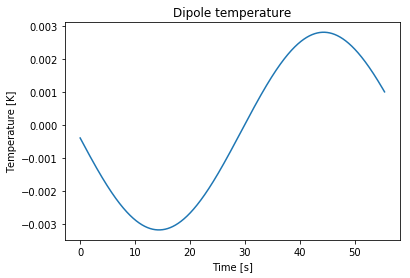

In [12]:
plt.plot(time[:10000], dipole[:10000])
plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.title("Dipole temperature")
plt.show()

### Remove galactic dipole signal

Apply a least squares method to remove the galactic dipole. We must use this method because the RAW data are voltages, while the galactic dipole data are temperatures. Since the RAW data are modulated by the dipole, it's possible to find a correlation of the type:
```
V - median(V) = G • (T - median(T))
```
where `V` are voltages (RAW data) and `T` are temperatures (galactic dipole). At this point, the final voltage will be:
```
V_final = V_raw - G • T_dipole
```

In [13]:
# Calculate the medians for the data and the dipole temperatures
median_data = sts.median(data)
median_dipole = sts.median(dipole)
# Rescale accordingly
data = data - median_data
dipole = dipole - median_dipole

# Evaluate the G factor
M = dipole[:, np.newaxis]*[0, 1]
p, res, rnk, s = lstsq(M, data)
G = p[1]

# Take the dipole out of the data
data_final = data - G * dipole

Plot data before and after the dipole correction.

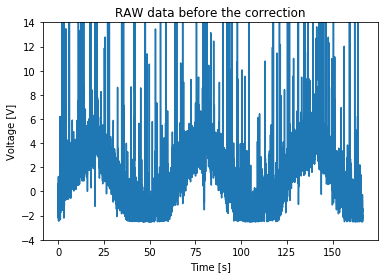

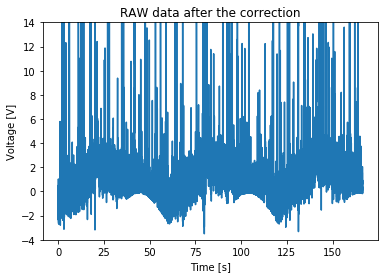

In [14]:
plt.plot(time[:30000], data[:30000])
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("RAW data before the correction")
axes = plt.gca()
axes.set_ylim([-4,14])
plt.show()

plt.plot(time[:30000], data_final[:30000])
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("RAW data after the correction")
axes = plt.gca()
axes.set_ylim([-4,14])
plt.show()

### Apply mask

In [15]:
# Take out from the data the directions corresponding to the galactic dust mask
data_cleaned = data_final[MASK == 0]
holed_raw = data[MASK == 0]
# Take out also on the time - this way I can have "holes" in the graph
time_cleaned = time[MASK == 0]

### Save data

In [16]:
if not os.path.exists(DIR):
    print("Creating '" + DIR + "' directory")
    os.makedirs(DIR)

np.savetxt(DIR + "/FINAL-cleaned_time.txt", time_cleaned)
np.savetxt(DIR + "/FINAL-cleaned_data.txt", data_cleaned)

Creating 'ris/OD095_143-5' directory


## Plot data

In [17]:
if not os.path.exists(DIR + "/plots"):
    print("Creating '" + DIR + "/plots' directory")
    os.makedirs(DIR + "/plots")

Creating 'ris/OD095_143-5/plots' directory


### Galactic dipole - first `120s`

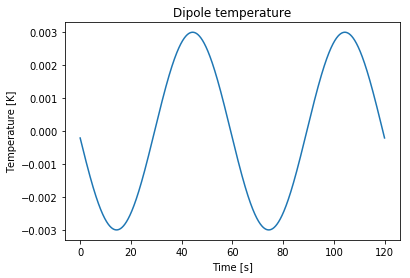

In [18]:
index = time < 120.
plt.plot(time[index], dipole[index])
plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.title("Dipole temperature")
plt.savefig(DIR + "/plots/dipole_example.png", dpi=600)
plt.show()
plt.close()

### Comparison between RAW data and cleaned data - first `30s`

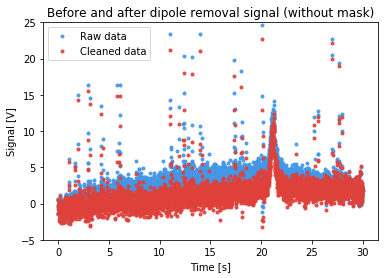

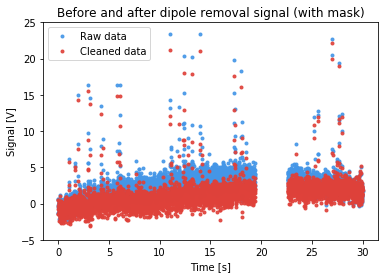

In [19]:
index = time < 30.
plt.plot(time[index], data[index], marker='.', linestyle='none', color='#4496e7', alpha=0.9, label="with dipole")
plt.plot(time[index], data_final[index], marker='.', linestyle='none', color='#df413a', alpha=0.9, label="without dipole")
#plt.plot(time[index], dipole[index]*10**-4)
plt.title("Before and after dipole removal signal (without mask)")
plt.xlabel("Time [s]")
plt.ylabel("Signal [V]")
plt.legend(["Raw data", "Cleaned data"])
axes = plt.gca()
axes.set_ylim([-5,25])
plt.savefig(DIR + "/plots/first-data_raw_signal.png", dpi=600)
plt.show()
plt.close()

index = time_cleaned < 30.
plt.plot(time_cleaned[index], holed_raw[index], marker='.', linestyle='none', color='#4496e7',  alpha=0.9, label="with dipole")
plt.plot(time_cleaned[index], data_cleaned[index], marker='.', linestyle='none', color='#df413a', alpha=0.9, label="without dipole")
plt.title("Before and after dipole removal signal (with mask)")
plt.xlabel("Time [s]")
plt.ylabel("Signal [V]")
plt.legend(["Raw data", "Cleaned data"])
axes = plt.gca()
axes.set_ylim([-5,25])
plt.savefig(DIR + "/plots/first-data_cleaned_signal.png", dpi=600)
plt.show()
plt.close()

### Comparison between RAW data and cleaned data - random `30s`